<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [51]:
# !pip install gdown -q

In [1]:
# import gdown

# url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
# output = 'Data.zip'
# gdown.download(url, output, quiet=False)

In [2]:
# import zipfile

# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall('./')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from psi.psi import calculate_psi

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [4]:
features = pd.read_csv('data/AGGS_FINAL.csv').drop('Unnamed: 0', axis=1)
contracts = pd.read_csv('data/CONTRACTS_FINAL.csv').drop('Unnamed: 0', axis=1)
campaigns = pd.read_csv('data/CAMPAINGS.csv').drop('Unnamed: 0', axis=1)
people_in_campaigns = pd.read_csv('data/PEOPLE_IN_CAMPAINGS_FINAL.csv').drop('Unnamed: 0', axis=1)

In [5]:
features.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760000 entries, 0 to 2759999
Data columns (total 13 columns):
 #   Column     Dtype  
---  ------     -----  
 0   x1         float64
 1   x2         float64
 2   x3         float64
 3   x4         float64
 4   x5         float64
 5   x6         float64
 6   x7         float64
 7   x8         float64
 8   x9         float64
 9   report_dt  object 
 10  user_id    int64  
 11  age        int64  
 12  city       object 
dtypes: float64(9), int64(2), object(2)
memory usage: 273.7+ MB


`Нужно привести report_dt в формат даты.`

In [7]:
features['report_dt'] = pd.to_datetime(features['report_dt'], format='%Y-%m-%d')

In [8]:
features['report_dt'].describe()

count                          2760000
mean     2025-01-09 12:00:00.000000256
min                2024-09-30 00:00:00
25%                2024-11-30 00:00:00
50%                2025-01-15 12:00:00
75%                2025-02-28 00:00:00
max                2025-03-31 00:00:00
Name: report_dt, dtype: object

`В этом атрибуте информативен только месяц.`

In [9]:
features['user_id'].unique().shape[0] == features.shape[0]

False

`user_id принимает неуникальные значения.`

In [10]:
contracts.head()

,user_id,contract_date,product_id,contract_id
0,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,2079035,2024-11-08,1,0001_2024-11-08_2079035
2,103088,2024-11-13,1,0001_2024-11-13_103088
3,2026788,2024-11-02,1,0001_2024-11-02_2026788
4,52269,2024-11-17,1,0001_2024-11-17_52269


In [11]:
contracts['product_id'].unique()

array([1])

`product_id принимает только одно значения, cоответсвующие продукту 0001. Этот атрибут можно удалить.`

In [12]:
contracts.drop('product_id', axis=1, inplace=True)

In [13]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286316 entries, 0 to 286315
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        286316 non-null  int64 
 1   contract_date  286316 non-null  object
 2   contract_id    286316 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.6+ MB


`Нужно привести contract_date в формат даты.`

In [14]:
contracts['contract_date'] = pd.to_datetime(contracts['contract_date'], format='%Y-%m-%d')

In [15]:
contracts['contract_date'].describe()

count                           286316
mean     2024-11-13 13:16:45.529555200
min                2024-11-01 00:00:00
25%                2024-11-08 00:00:00
50%                2024-11-13 00:00:00
75%                2024-11-17 00:00:00
max                2024-11-28 00:00:00
Name: contract_date, dtype: object

`Все покупки осуществлялись в ноября.`

In [16]:
contracts['user_id'].unique().shape[0] == contracts.shape[0]

True

`Клиенты совершали только одну покупку в течение ноября.`

In [17]:
campaigns.head()

,campaing_id,product_id,channel
0,iddqd,1,push
1,idclip,1,sms
2,iddt,1,banner
3,idkfa,1,other_ads


In [18]:
campaigns['channel'].unique()

array(['push', 'sms', 'banner', 'other_ads'], dtype=object)

In [19]:
campaigns['product_id'].unique()

array([1])

`product_id принимает только одно значение, соответсвующие продукту 0001. Этот атрибут можно удалить.`

In [20]:
campaigns.drop('product_id', axis=1, inplace=True)

In [21]:
people_in_campaigns.head()

,campaing_id,user_id,t_flag,delivery_date
0,idclip,1099975,1,2024-11-06
1,iddqd,1162,1,2024-11-08
2,iddqd,42991,1,2024-11-07
3,idclip,142343,0,unknown
4,iddqd,24623,0,unknown


`delivery_date нужно привести к типу даты, значения unknown принять за пропуск.`

In [22]:
people_in_campaigns['delivery_date'] = pd.to_datetime(people_in_campaigns['delivery_date'], format='%Y-%m-%d', errors='coerce')

In [23]:
people_in_campaigns['delivery_date'].describe()

count                           260000
mean     2024-11-05 20:42:25.919999744
min                2024-11-04 00:00:00
25%                2024-11-05 00:00:00
50%                2024-11-06 00:00:00
75%                2024-11-07 00:00:00
max                2024-11-08 00:00:00
Name: delivery_date, dtype: object

`Компании проводились только в ноябре.`

`Объединим people_in_campaigns и campaigns.`

In [24]:
people_in_campaigns_merge_campaigns = people_in_campaigns.merge(right=campaigns,
                          how='left',
                          on='campaing_id',
                          validate='many_to_one')

people_in_campaigns_merge_campaigns

,campaing_id,user_id,t_flag,delivery_date,channel
0,idclip,1099975,1,2024-11-06,sms
1,iddqd,1162,1,2024-11-08,push
2,iddqd,42991,1,2024-11-07,push
3,idclip,142343,0,NaT,sms
4,iddqd,24623,0,NaT,push
...,...,...,...,...,...
519995,iddt,4108275,1,2024-11-04,banner
519996,iddqd,131927,1,2024-11-06,push
519997,idclip,1074765,1,2024-11-05,sms
519998,iddqd,73995,0,NaT,push


`Если у клиента t_flag принимает значение 0, значение channel нужно изменить на no_comm.`

In [25]:
people_in_campaigns_merge_campaigns['channel'] = people_in_campaigns_merge_campaigns.apply(lambda x: 'no_comm' if x['t_flag'] == 0 else x['channel'], axis=1)
people_in_campaigns_merge_campaigns

,campaing_id,user_id,t_flag,delivery_date,channel
0,idclip,1099975,1,2024-11-06,sms
1,iddqd,1162,1,2024-11-08,push
2,iddqd,42991,1,2024-11-07,push
3,idclip,142343,0,NaT,no_comm
4,iddqd,24623,0,NaT,no_comm
...,...,...,...,...,...
519995,iddt,4108275,1,2024-11-04,banner
519996,iddqd,131927,1,2024-11-06,push
519997,idclip,1074765,1,2024-11-05,sms
519998,iddqd,73995,0,NaT,no_comm


In [26]:
people_in_campaigns_merge_campaigns['user_id'].unique().shape[0] == people_in_campaigns_merge_campaigns.shape[0]

False

`Клиенты в компаниях не уникальны. Вернемся к этому вопросу позднее.`

`Создадим таргет.`

In [27]:
campaigns_contracts = people_in_campaigns_merge_campaigns.merge(right=contracts,
                                                                how='left',
                                                                on='user_id',
                                                                validate='many_to_one')
campaigns_contracts

,campaing_id,user_id,t_flag,delivery_date,channel,contract_date,contract_id
0,idclip,1099975,1,2024-11-06,sms,2024-11-11,0001_2024-11-11_1099975
1,iddqd,1162,1,2024-11-08,push,2024-11-13,0001_2024-11-13_1162
2,iddqd,42991,1,2024-11-07,push,NaT,NaN
3,idclip,142343,0,NaT,no_comm,2024-11-17,0001_2024-11-17_142343
4,iddqd,24623,0,NaT,no_comm,NaT,NaN
...,...,...,...,...,...,...,...
519995,iddt,4108275,1,2024-11-04,banner,2024-11-15,0001_2024-11-15_4108275
519996,iddqd,131927,1,2024-11-06,push,2024-11-27,0001_2024-11-27_131927
519997,idclip,1074765,1,2024-11-05,sms,NaT,NaN
519998,iddqd,73995,0,NaT,no_comm,NaT,NaN


In [28]:
def create_target(x):
    """
    Создание таргета.
    """
    if not pd.isna(x['contract_date']):
        if x['t_flag'] == 1 and x['contract_date'] >= x['delivery_date'] and (x['contract_date'] - x['delivery_date']).days / 7 <= 2:
            return 1
        elif x['t_flag'] == 0 and (x['contract_date'] - pd.Timestamp('2024-11-01')).days <= 21:
            return 1
    return 0

campaigns_contracts['target'] = campaigns_contracts.apply(create_target, axis=1)

campaigns_contracts

,campaing_id,user_id,t_flag,delivery_date,channel,contract_date,contract_id,target
0,idclip,1099975,1,2024-11-06,sms,2024-11-11,0001_2024-11-11_1099975,1
1,iddqd,1162,1,2024-11-08,push,2024-11-13,0001_2024-11-13_1162,1
2,iddqd,42991,1,2024-11-07,push,NaT,NaN,0
3,idclip,142343,0,NaT,no_comm,2024-11-17,0001_2024-11-17_142343,1
4,iddqd,24623,0,NaT,no_comm,NaT,NaN,0
...,...,...,...,...,...,...,...,...
519995,iddt,4108275,1,2024-11-04,banner,2024-11-15,0001_2024-11-15_4108275,1
519996,iddqd,131927,1,2024-11-06,push,2024-11-27,0001_2024-11-27_131927,0
519997,idclip,1074765,1,2024-11-05,sms,NaT,NaN,0
519998,iddqd,73995,0,NaT,no_comm,NaT,NaN,0


In [29]:
campaigns_contracts.drop(['contract_date', 'contract_id'], axis=1, inplace=True)

`Отделим контрольные группы от целевых.`

In [30]:
target_campaigns = campaigns_contracts[~campaigns_contracts['delivery_date'].isna()]
control_campaigns = campaigns_contracts[campaigns_contracts['delivery_date'].isna()].drop('delivery_date', axis=1)

In [31]:
target_campaigns

,campaing_id,user_id,t_flag,delivery_date,channel,target
0,idclip,1099975,1,2024-11-06,sms,1
1,iddqd,1162,1,2024-11-08,push,1
2,iddqd,42991,1,2024-11-07,push,0
6,idkfa,2008409,1,2024-11-04,other_ads,0
7,iddt,4045746,1,2024-11-04,banner,0
...,...,...,...,...,...,...
519994,idclip,1085198,1,2024-11-07,sms,0
519995,iddt,4108275,1,2024-11-04,banner,1
519996,iddqd,131927,1,2024-11-06,push,0
519997,idclip,1074765,1,2024-11-05,sms,0


`Проверка по полю t_flag.`

In [32]:
target_campaigns['t_flag'].unique()

array([1])

In [33]:
control_campaigns

,campaing_id,user_id,t_flag,channel,target
3,idclip,142343,0,no_comm,1
4,iddqd,24623,0,no_comm,0
5,iddt,4001330,0,no_comm,0
9,idkfa,2101471,0,no_comm,1
10,idkfa,2086041,0,no_comm,0
...,...,...,...,...,...
519987,iddqd,94299,0,no_comm,0
519990,idkfa,2020830,0,no_comm,0
519992,iddqd,98949,0,no_comm,0
519993,idclip,81278,0,no_comm,0


`Проверка по полю t_flag.`

In [34]:
control_campaigns['t_flag'].unique()

array([0])

In [35]:
len(set(control_campaigns['user_id'].unique()).intersection(set(target_campaigns['user_id'].unique())))

60000

`60000 клиентов попали в обе группы одновременно.`

In [36]:
for campaign in campaigns['campaing_id']:
    print(f'{campaign}:')
    filter_target = (target_campaigns['campaing_id'] == campaign)
    filter_control = (control_campaigns['campaing_id'] == campaign)
    intersection_len = len(set(control_campaigns[filter_control]['user_id']).intersection(set(target_campaigns[filter_target]['user_id'])))
    print(f'intersection length: {intersection_len}')

iddqd:
intersection length: 0
idclip:
intersection length: 0
iddt:
intersection length: 0
idkfa:
intersection length: 0


`В рамках одной компании пересечений нет, следовательно нужно искать пересечения между разными компаниями.`

In [37]:
cross_tab = pd.crosstab(people_in_campaigns_merge_campaigns['user_id'], 
                        people_in_campaigns_merge_campaigns['campaing_id'])

cross_tab.T.dot(cross_tab) 

campaing_id,idclip,iddqd,iddt,idkfa
campaing_id,,,,
idclip,120000,60000,0,0
iddqd,60000,160000,0,0
iddt,0,0,120000,0
idkfa,0,0,0,120000


In [38]:
idclip_iddqd = people_in_campaigns_merge_campaigns[people_in_campaigns_merge_campaigns['campaing_id'].isin(['idclip', 'iddqd'])]

idclip_iddqd[idclip_iddqd['user_id'].duplicated()].groupby(['campaing_id', 't_flag'])['user_id'].count()

campaing_id  t_flag
idclip       0         29939
iddqd        1         30061
Name: user_id, dtype: int64

In [39]:
idclip_iddqd[idclip_iddqd['user_id'].duplicated(keep=False)].groupby(['campaing_id', 't_flag'])['user_id'].count()

campaing_id  t_flag
idclip       0         60000
iddqd        1         60000
Name: user_id, dtype: int64

`С учетом того, что внутри одной компании пересечений нет, обе компании имееют некорректные данные: 29939 клиентов находятся в контрольной группе компании idclip и одновременно в целевой группе iddqd, 30061 клиент находятся в целевой группе iddqd и в контрольной группе idclip. Для этих компаний моделирование не нужно проводить, поскольку в них есть клиенты, находящиеся под влиянием другой компании, а модель uplift этого не учитывает.`

In [40]:
campaigns_contracts.groupby(['campaing_id', 't_flag'])['target'].mean()

campaing_id  t_flag
idclip       0         0.684917
             1         0.201167
iddqd        0         0.202150
             1         0.601738
iddt         0         0.400733
             1         0.602717
idkfa        0         0.400733
             1         0.602717
Name: target, dtype: float64

In [41]:
campaign_dict = {}

for campaign in campaigns_contracts.campaing_id.unique():
    filter = (campaigns_contracts['campaing_id'] == campaign)
    df = campaigns_contracts[filter]
    target_mean = df[df['t_flag'] == 1]['target'].mean()
    control_mean = df[df['t_flag'] == 0]['target'].mean()
    campaign_dict[campaign] = target_mean - control_mean

In [42]:
campaign_dict

{'idclip': -0.48374999999999996,
 'iddqd': 0.39958750000000004,
 'iddt': 0.20198333333333335,
 'idkfa': 0.20198333333333335}

In [43]:
campaigns

,campaing_id,channel
0,iddqd,push
1,idclip,sms
2,iddt,banner
3,idkfa,other_ads


`Для компании по sms uplift получился отрицательным, что говорит о том, что клиенты охотнее преобретали продукт без рекламы чем с ней.`

`Самый большой положительный uplift получился у компании push-уведомлениям, у компаний с рекламой через баннеры и другие виды рекламы uplift получился одинаковый (положительный).`

`При этом стоит учитывать, что компании по рекламе через sms и push-уведомления имееют общих клиентов, поэтому отрицательный uplift у sms рекламы мог возникнуть, например, из-за того, что было много убеждаемых клиентов в контрольной группе sms, которые купили продукт после рекламы через push-уведомления. И наооборот: высокий положительный uplift у push-уведомлений мог возникнуть из-за того, что клиенты типа "не беспокоить", которые не купили продукт после sms рекламы, попали в контрольную группу для push-уведомлений.`

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

`Получим признаки для клиентов в ноябре.`

In [44]:
campaigns_contracts.drop('delivery_date', axis=1, inplace=True)
campaigns_contracts

,campaing_id,user_id,t_flag,channel,target
0,idclip,1099975,1,sms,1
1,iddqd,1162,1,push,1
2,iddqd,42991,1,push,0
3,idclip,142343,0,no_comm,1
4,iddqd,24623,0,no_comm,0
...,...,...,...,...,...
519995,iddt,4108275,1,banner,1
519996,iddqd,131927,1,push,0
519997,idclip,1074765,1,sms,0
519998,iddqd,73995,0,no_comm,0


In [45]:
features_november = features[(features['report_dt'].dt.year == 2024) & (features['report_dt'].dt.month == 11)]

In [46]:
features_november['user_id'].unique().shape[0] == features_november.shape[0]

True

`Клиенты в ноябре уникальны.`

In [47]:
campaigns_contracts_features = campaigns_contracts.merge(right=features_november,
                                                         how='inner',
                                                         on='user_id',
                                                         validate='many_to_one').drop('report_dt', axis=1)
campaigns_contracts_features

,campaing_id,user_id,t_flag,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,idclip,1099975,1,sms,1,-2.947076,1.304330,-2.432121,2.607666,1.115625,1.029585,-2.140406,1.009034,3.804885,42,Moscow
1,iddqd,1162,1,push,1,1.119404,0.771651,0.821400,0.045399,1.080068,-1.186944,-3.125925,0.020622,-1.100280,39,Moscow
2,iddqd,42991,1,push,0,1.387886,3.212619,3.230002,-0.964792,-0.435239,-0.802278,0.028905,-0.889631,-2.145822,43,Moscow
3,idclip,142343,0,no_comm,1,1.626777,0.603416,1.392187,0.585611,0.157298,-0.696976,-0.028287,-1.479436,-2.888128,39,Smolensk
4,iddqd,24623,0,no_comm,0,1.137531,2.551898,3.591135,-0.232508,-0.507432,2.449943,-0.546361,1.521589,0.163554,39,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519995,iddt,4108275,1,banner,1,-0.325959,0.649431,-0.191381,3.239630,1.735254,-0.372829,-0.101146,-0.749057,-0.314231,36,Ufa
519996,iddqd,131927,1,push,0,-0.162328,1.318496,0.466231,1.251345,1.754851,0.680106,0.942569,1.763249,1.668054,42,Ufa
519997,idclip,1074765,1,sms,0,0.503339,1.419597,1.706254,1.217425,0.651066,-1.195104,-0.322297,0.960853,0.317981,28,Moscow
519998,iddqd,73995,0,no_comm,0,-0.381535,-2.773029,-0.569012,3.993058,0.836398,0.111593,-1.363501,1.094257,1.315596,29,Smolensk


In [48]:
campaigns_contracts_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520000 entries, 0 to 519999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   campaing_id  520000 non-null  object 
 1   user_id      520000 non-null  int64  
 2   t_flag       520000 non-null  int64  
 3   channel      520000 non-null  object 
 4   target       520000 non-null  int64  
 5   x1           520000 non-null  float64
 6   x2           520000 non-null  float64
 7   x3           520000 non-null  float64
 8   x4           520000 non-null  float64
 9   x5           520000 non-null  float64
 10  x6           520000 non-null  float64
 11  x7           520000 non-null  float64
 12  x8           520000 non-null  float64
 13  x9           520000 non-null  float64
 14  age          520000 non-null  int64  
 15  city         520000 non-null  object 
dtypes: float64(9), int64(4), object(3)
memory usage: 63.5+ MB


`Пропусков нет.`

In [75]:
numeric = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']

In [50]:
campaigns_contracts_features.groupby(['campaing_id', 't_flag'])[numeric].mean().round(2)

x1    x2    x3    x4    x5   x6    x7    x8    x9    age
campaing_id t_flag                                                            
idclip      0       0.80  0.80  0.80  1.00  0.79 -0.0 -0.99  0.55 -0.33  32.46
            1       0.81  0.80  0.80  1.00  0.80 -0.0 -1.00  0.55 -0.33  32.54
iddqd       0       0.81  0.80  0.81  1.00  0.80  0.0 -1.00  0.56 -0.34  32.50
            1       0.80  0.80  0.80  1.00  0.79 -0.0 -0.99  0.55 -0.33  32.45
iddt        0       0.80  0.80  0.80  1.01  0.80  0.0 -1.00  0.56 -0.32  32.53
            1       0.80  0.79  0.80  1.01  0.80  0.0 -0.99  0.56 -0.32  32.50
idkfa       0       0.79  0.79  0.79  1.00  0.81  0.0 -1.00  0.55 -0.32  32.57
            1       0.80  0.80  0.80  1.01  0.81  0.0 -1.00  0.56 -0.32  32.49

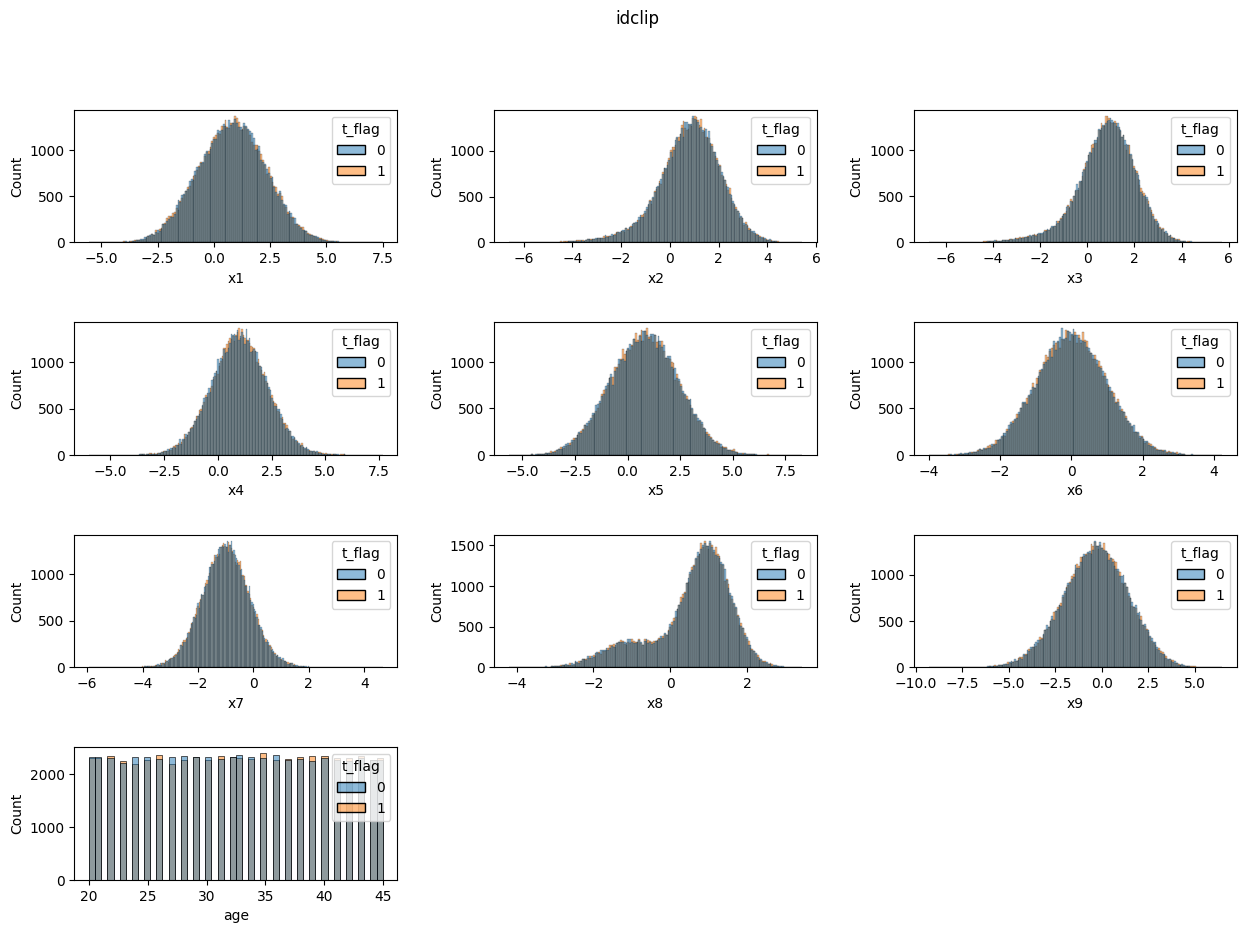

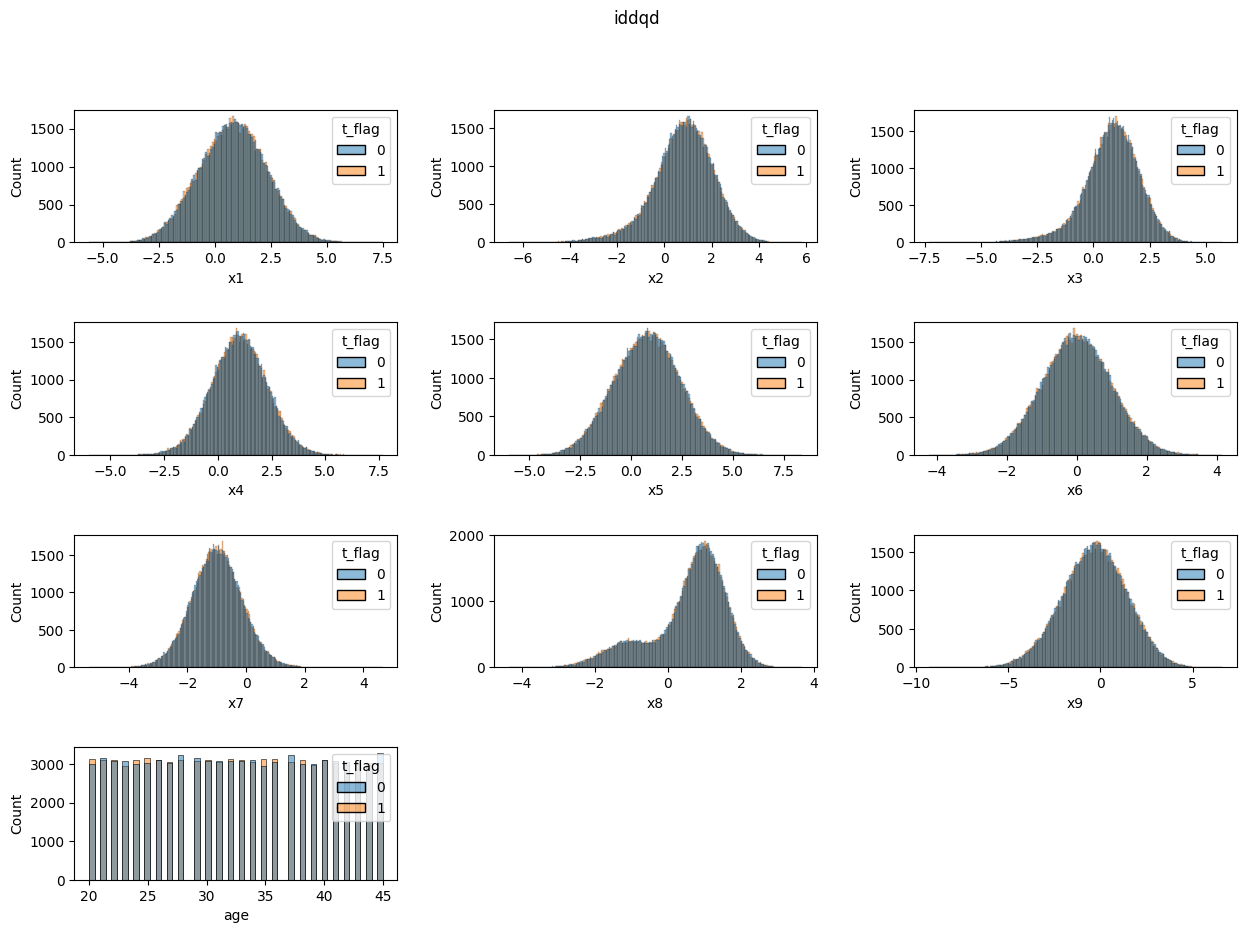

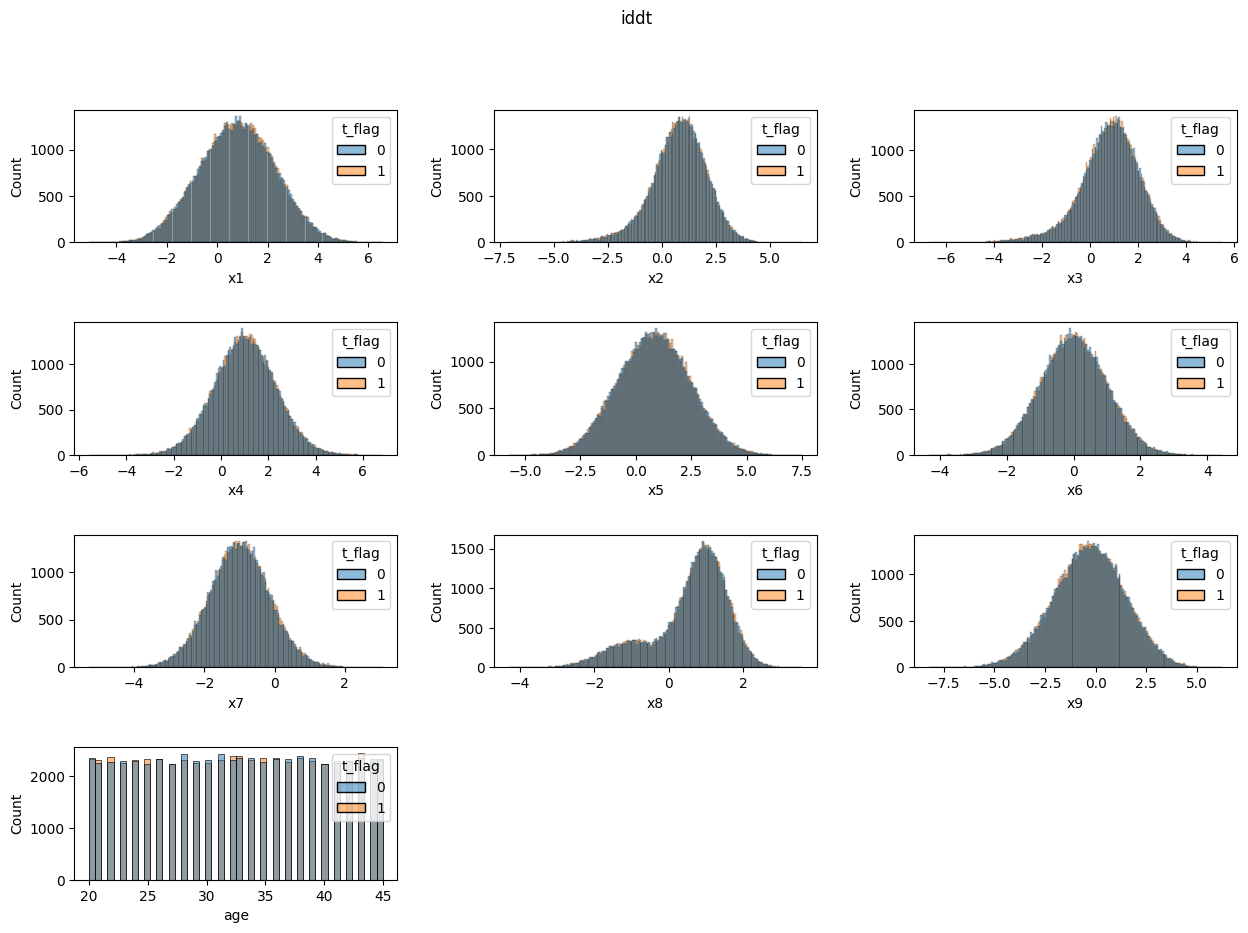

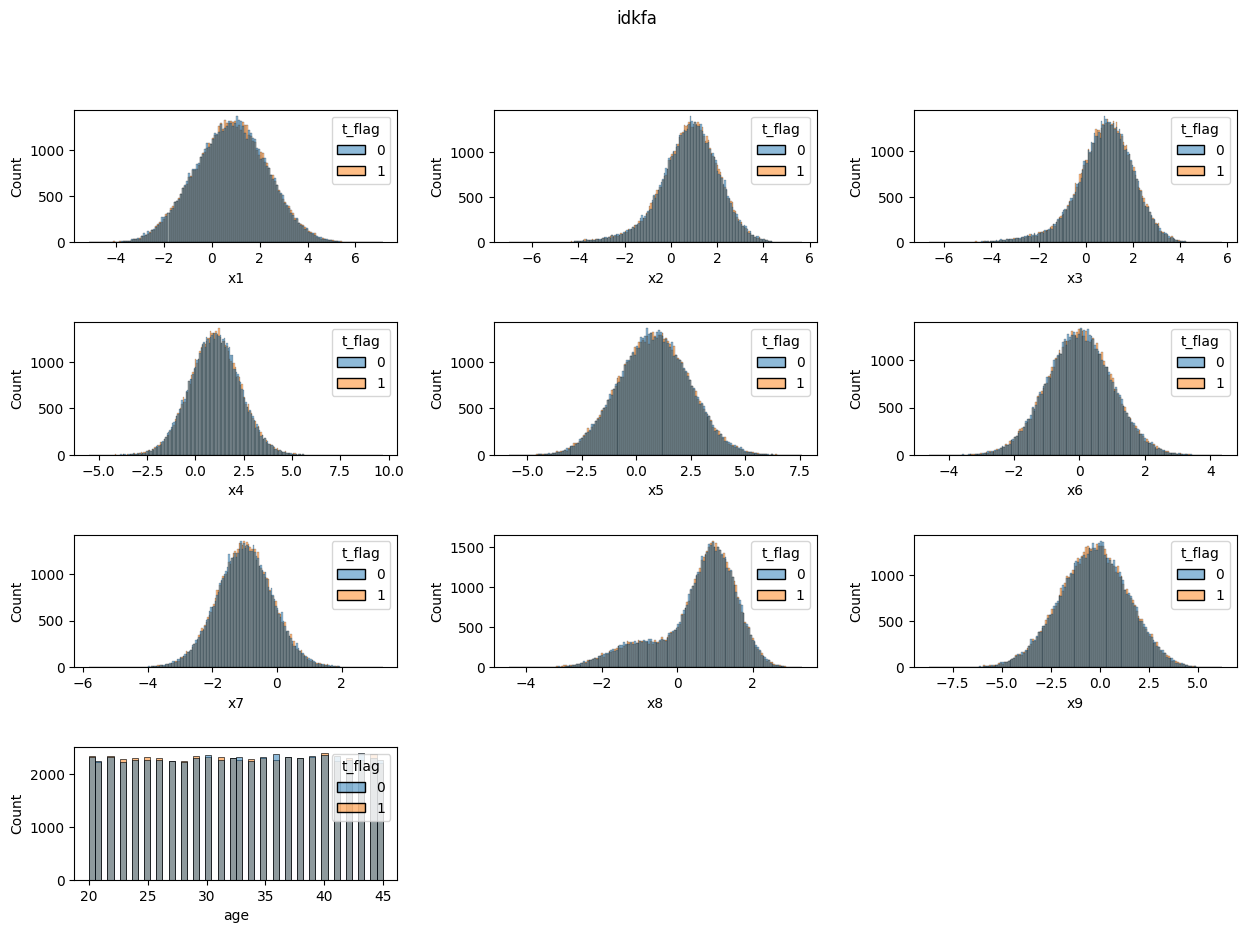

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

def dist_plots(campaign):
    """
    Построить графики распределений для каждого признака для контрольной и целевой группы.
    """
    data = campaigns_contracts_features[campaigns_contracts_features['campaing_id'] == campaign]
    
    nrows = 4
    ncols = 3
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.6)
    
    for row in range(nrows):
        for col in range(ncols):
            k = row * ncols + col
            if k >= len(numeric):
                ax[row, col].axis('off')
                continue
            sns.histplot(data=data, 
                         x=numeric[k],
                         hue='t_flag',
                         ax=ax[row, col])
    
    fig.suptitle(campaign)
    plt.show()        
    
for campaign in campaigns_contracts_features.campaing_id.unique():
    dist_plots(campaign)

`Разбиение на контрольную и целевую группу в рамках одной компании для каждого численного признака одинаковое. `

In [89]:
for campaign in campaigns_contracts_features.campaing_id.unique():
    data = campaigns_contracts_features[campaigns_contracts_features['campaing_id'] == campaign]
    print(f'{campaign}:')
    for col in numeric:
        psi = calculate_psi(expected=data[data['t_flag'] == 0][col],
                            actual=data[data['t_flag'] == 1][col])
        print(f'    psi для признака {col} равно {psi}')

idclip:
    psi для признака x1 равно 0.00039718338737256985
    psi для признака x2 равно 0.000188149272522409
    psi для признака x3 равно 7.290676332659414e-05
    psi для признака x4 равно 0.0002897836069222927
    psi для признака x5 равно 0.000291156648308333
    psi для признака x6 равно 0.00026095126919436926
    psi для признака x7 равно 0.00040065119518615486
    psi для признака x8 равно 0.0003519147633697375
    psi для признака x9 равно 0.0002760928307915072
    psi для признака age равно 0.000261977328001752
iddqd:
    psi для признака x1 равно 0.00014384548582848367
    psi для признака x2 равно 0.0003845380219640032
    psi для признака x3 равно 0.0002138103727775115
    psi для признака x4 равно 5.8243989635520936e-05
    psi для признака x5 равно 0.0001248096759157833
    psi для признака x6 равно 6.0356780988774055e-05
    psi для признака x7 равно 6.873909426209068e-05
    psi для признака x8 равно 0.00023080550089269478
    psi для признака x9 равно 0.000163217327

`Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.05).`

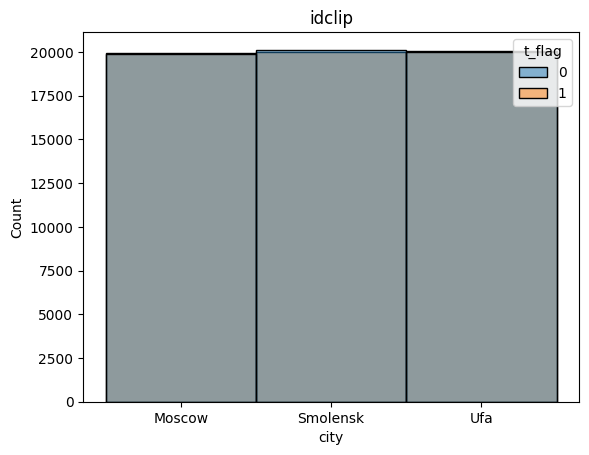

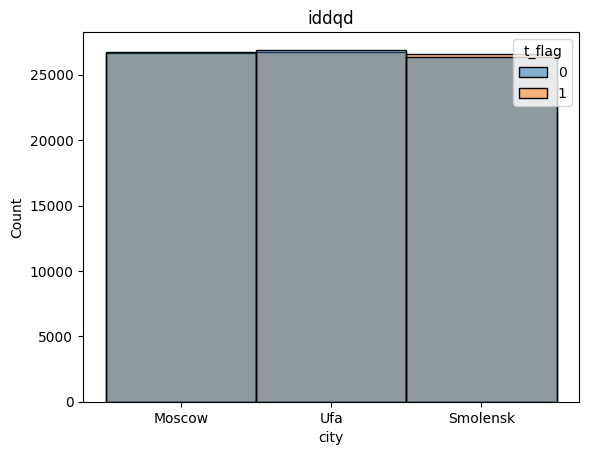

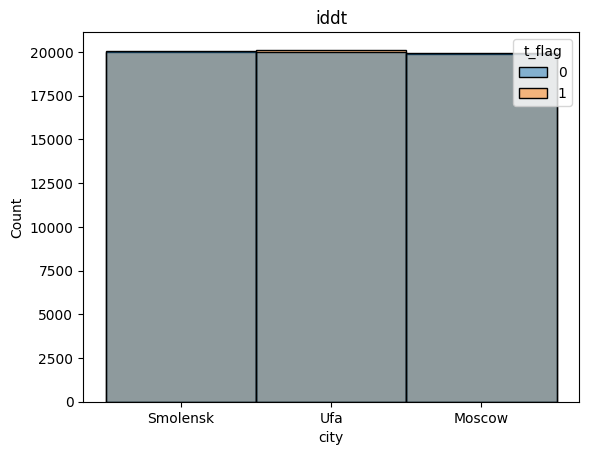

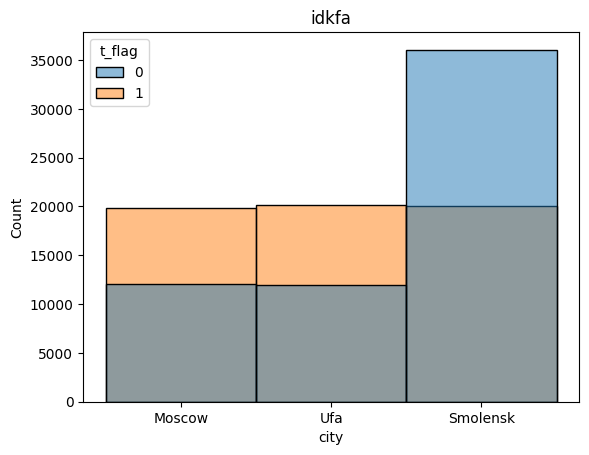

In [ ]:
for campaign in campaigns_contracts_features.campaing_id.unique():
    data = campaigns_contracts_features[campaigns_contracts_features['campaing_id'] == campaign]
    fig, ax = plt.subplots()
    sns.histplot(data=data, 
                 x='city',
                 hue='t_flag',
                 ax=ax)
    ax.set_title(campaign)
    plt.show()

`В компании idkfa категориальный признак city имеет разное распределение в целевой и контрольной группе.`

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [ ]:
# ваш код здесь

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# ваш код здесь

### ваши выводы здесь